#### Importación de librerias

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from datetime import datetime
from sklearn.ensemble import IsolationForest
import folium
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.dummy import DummyClassifier # Import the DummyClassifier class
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix, f1_score, precision_score, roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

#### Funciones

In [319]:
# Renombre de columnas
def rename_cols(df,cols,prefix):
    new_feats=[prefix+col for col in cols]
    df=df.rename(columns=dict(zip(cols,new_feats)))
    return df

# Completitud
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

# Filtro de completitud
def filtrar_por_completitud(df, umbral=90):
    """
    Filtra las columnas de un DataFrame que tengan una completitud menor al umbral indicado.
    Imprime las columnas eliminadas junto con su porcentaje de completitud.
    Devuelve el DataFrame filtrado.
    """
    # Calcular completitud
    comple = pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple = comple.rename(columns={"index": "columna", 0: "total"})
    comple["completitud"] = (1 - comple["total"] / df.shape[0]) * 100

    # Identificar columnas que no cumplen el umbral
    eliminadas = comple.loc[comple["completitud"] < umbral, ["columna", "completitud"]]
    conservadas = comple.loc[comple["completitud"] >= umbral, "columna"]

    # Imprimir reporte
    if not eliminadas.empty:
        print("📉 Columnas eliminadas por baja completitud:")
        for _, row in eliminadas.iterrows():
            print(f" - {row['columna']}: {row['completitud']:.2f}% de completitud")
    else:
        print("✅ No se eliminaron columnas, todas cumplen el umbral.")

    # Retornar DataFrame filtrado
    return df[conservadas]

# Filtro de variables unarias ponderadas
def unarias_ponderadas(df, umbral=0.95, mostrar_sesgo=True):
    """
    Detecta variables en las que una categoría supera el umbral de proporción.
    Puede además mostrar el sesgo (distribución porcentual) de cada variable detectada.
    """
    unarias = []

    for v in df.columns:
        # Distribución de frecuencias relativas
        evaluacion = df[v].value_counts(normalize=True).reset_index()
        evaluacion.columns = [v, "proporcion"]

        # Verificar si la categoría dominante supera el umbral
        if evaluacion["proporcion"].iloc[0] > umbral:
            unarias.append(v)

            if mostrar_sesgo:
                print(f"\n🔍 Variable: {v}")
                print(evaluacion.to_string(index=False, formatters={"proporcion": "{:.2%}".format}))

    if not unarias:
        print("✅ No se encontraron variables unarias por encima del umbral.")

    return unarias


def descriptivos(df, tipo_variable="v_"):
    # Seleccionar solo columnas que empiezan con tipo_variable
    cols = df.columns[df.columns.str.startswith(tipo_variable)]

    for col in cols:
        print(col)

        value_counts = df[col].value_counts(normalize=True)
        mydf = pd.DataFrame(value_counts)
        mydf['cumulativo'] = df[col].value_counts().cumsum() / df[col].value_counts().sum()
        mydf['total'] = df[col].value_counts()
        mydf['total_cumulativo'] = df[col].value_counts().cumsum()

        display(mydf)
        print("\n")


def plot_eda_cat(df, prefix, title):
    """
    Grafica variables categóricas (que comienzan con 'prefix') como barras horizontales.
    Muestra frecuencias y porcentajes, ajustando la altura según el número de categorías.
    """

    # Filtrar columnas que empiezan con el prefijo
    lista_categoricas = [col for col in df.columns if col.startswith(prefix)]

    for current_cat in lista_categoricas:
        # Frecuencias absolutas y totales
        counts = df[current_cat].value_counts().sort_values(ascending=True)
        total = counts.sum()

        # Altura dinámica según número de categorías
        n_cat = len(counts)
        fig_height = max(400, 30 * n_cat + 150)

        # Gráfico de barras
        fig = go.Figure([
            go.Bar(
                x=counts.values,
                y=counts.index,
                orientation='h',
                text=[f"{v} ({v/total*100:.1f}%)" for v in counts],
                textposition='auto',
                marker=dict(color='steelblue')
            )
        ])

        # Diseño
        fig.update_layout(
            title=dict(text=f"<b>{title} – {current_cat}</b>", x=0.5, font=dict(size=20)),
            xaxis_title="Frecuencia",
            yaxis_title="Categoría",
            width=800,
            height=fig_height,
            margin=dict(t=80, l=180, r=50, b=60),
            showlegend=False,
            template="plotly_white"
        )

        # Mostrar todas las categorías en el eje Y
        fig.update_yaxes(tickmode='array', tickvals=list(counts.index), ticktext=list(counts.index))

        fig.show()






def plot_eda_cat2(df, prefix, titulo, dividir_por_target=True, tgt_col=None, max_unique_for_classif=10):
    """
    - Grafica variables categóricas que empiezan con prefix.
    - Si dividir_por_target=True y el target es binario → gráfica agrupada (side-by-side).
    - Barras SIEMPRE horizontales.
    - No cambia etiquetas del target.
    """

    columnas = [c for c in df.columns if c.startswith(prefix)]
    if not columnas:
        print("⚠️ No hay columnas que empiecen con ese prefijo.")
        return

    # Determinar target (si aplica)
    target = None
    if dividir_por_target:
        if tgt_col is not None and tgt_col in df.columns:
            target = tgt_col
        else:
            # buscar la primera columna que empiece con tgt
            tgt_candidates = [c for c in df.columns if c.startswith("tgt")]
            if len(tgt_candidates) > 0:
                target = tgt_candidates[0]

    for col in columnas:

        # -----------------------------
        # CASO 1: sin división por target
        # -----------------------------
        if not dividir_por_target or target is None:
            counts = df[col].value_counts().sort_values()
            labels = counts.index.astype(str)
            values = counts.values
            total = values.sum()

            fig = go.Figure(
                go.Bar(
                    x=values,
                    y=labels,
                    orientation="h",
                    text=[f"{v} ({v/total*100:.1f}%)" for v in values],
                    textposition="auto"
                )
            )

            fig.update_layout(
                title=f"{titulo} – {col}",
                xaxis_title="Frecuencia",
                yaxis_title=col,
                template="plotly_white",
                width=1100,
                height=max(400, 40 * len(labels))
            )
            fig.show()
            continue

        # -----------------------------
        # CASO 2: intentar agrupar por target
        # -----------------------------
        valores_target = df[target].dropna().unique()

        es_clasificacion_binaria = (
            len(valores_target) == 2 and len(valores_target) <= max_unique_for_classif
        )

        if not es_clasificacion_binaria:
            # fallback a gráfico normal
            counts = df[col].value_counts().sort_values()
            labels = counts.index.astype(str)
            values = counts.values
            total = values.sum()

            fig = go.Figure(
                go.Bar(
                    x=values,
                    y=labels,
                    orientation="h",
                    text=[f"{v} ({v/total*100:.1f}%)" for v in values],
                    textposition="auto"
                )
            )

            fig.update_layout(
                title=f"{titulo} – {col} (target no binario)",
                xaxis_title="Frecuencia",
                yaxis_title=col,
                template="plotly_white",
                width=1100,
                height=max(400, 40 * len(labels))
            )
            fig.show()
            continue

        # -----------------------------
        # CASO 3: agrupación horizontal por target binario
        # -----------------------------
        df_tmp = df[[col, target]].copy()
        df_tmp[target] = df_tmp[target].astype(str)

        tabla = pd.crosstab(df_tmp[col].astype(str), df_tmp[target])
        tabla = tabla.loc[tabla.sum(axis=1).sort_values().index]

        fig = go.Figure()
        colores = px.colors.qualitative.Set2

        categorias = tabla.index.astype(str)

        # Crear barras horizontales agrupadas
        for i, tgt_val in enumerate(tabla.columns):
            valores = tabla[tgt_val].values
            totales_categoria = tabla.sum(axis=1).values

            # texto de porcentaje por categoría
            texts = [
                f"{v} ({(v/t*100):.1f}%)" if t > 0 else "0 (0.0%)"
                for v, t in zip(valores, totales_categoria)
            ]

            fig.add_trace(
                go.Bar(
                    x=valores,
                    y=categorias,
                    name=str(tgt_val),
                    marker_color=colores[i % len(colores)],
                    orientation="h",
                    text=texts,
                    textposition="auto"
                )
            )

        fig.update_layout(
            title=f"{titulo} – {col} (agrupado por {target})",
            barmode="group",
            xaxis_title="Frecuencia",
            yaxis_title=col,
            template="plotly_white",
            legend_title=str(target),
            width=1100,
            height=max(450, 40 * len(categorias)),
            margin=dict(t=80, l=200, r=50, b=80)
        )

        fig.show()





def plot_eda_num(df, prefix='num_', titulo='Exploratory Data Analysis (EDA)'):
    """
    Genera histogramas con curva KDE + boxplot (abajo) para todas las variables numéricas 
    cuyo nombre contiene el prefijo indicado, mostrando una leyenda independiente
    dentro de cada subplot.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con las variables a analizar.
    prefix : str, opcional (por defecto 'num_')
        Prefijo que deben tener las columnas numéricas a analizar.
    titulo : str, opcional
        Título general mostrado en cada figura.
    """

    # --- Solo columnas que COMIENZAN con el prefijo ---
    lista_numericas = [col for col in df.columns if col.startswith(prefix)]
    print(f"Total de variables que cumplen con '{prefix}': {len(lista_numericas)}\n")

    for col in lista_numericas:
        x = df[col].dropna()

        # --- Histograma (densidad normalizada) ---
        hist_vals, bin_edges = np.histogram(x, bins=38, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # --- KDE ---
        kde = gaussian_kde(x)
        kde_x = np.linspace(x.min(), x.max(), 500)
        kde_y = kde(kde_x)

        # --- Estadísticos descriptivos ---
        skew = df[col].skew()
        mean = df[col].mean()
        median = df[col].median()

        # --- Subplots: histograma + boxplot ---
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            row_heights=[0.75, 0.25],
            vertical_spacing=0.08
        )

        # --- Histograma ---
        fig.add_trace(go.Bar(
            x=bin_centers,
            y=hist_vals,
            name="Histograma",
            marker=dict(color='rgba(70,130,180,0.7)', line=dict(color='white', width=1)),
            hovertemplate='Valor: %{x:.2f}<br>Densidad: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- KDE ---
        fig.add_trace(go.Scatter(
            x=kde_x,
            y=kde_y,
            mode="lines",
            name="KDE",
            line=dict(color="red", width=2, dash="dash"),
            hovertemplate='Valor: %{x:.2f}<br>Densidad KDE: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- Boxplot (abajo) ---
        fig.add_trace(go.Box(
            x=x,
            name="Boxplot",
            boxmean=True,
            marker_color='rgba(255,165,0,0.7)',
            line=dict(width=1),
            orientation='h',
            showlegend=False
        ), row=2, col=1)

        # --- Diseño ---
        fig.update_layout(
            title=dict(
                text=f"<b>{titulo} - {col}</b><br>Media: {mean:.2f}, Mediana: {median:.2f}, Asimetría: {skew:.2f}",
                x=0.5,
                font=dict(size=18)
            ),
            xaxis_title=col,
            yaxis_title="Densidad (escala normalizada)",
            yaxis_tickformat='.1e',  # notación científica (tipo 20n, 40n)
            width=800,
            height=600,
            template="plotly_white",
            showlegend=True,
            # 👇 Leyenda dentro del primer subplot
            legend=dict(
                x=0.98, y=0.95,
                xanchor='right', yanchor='top',
                bgcolor='rgba(255,255,255,0.6)',
                bordercolor='gray',
                borderwidth=1,
                font=dict(size=12)
            ),
            margin=dict(t=100, l=70, r=40, b=70)
        )

        fig.update_yaxes(title_text="Boxplot", row=2, col=1, showticklabels=False)
        fig.show()

# Plot matriz de correlación
def plot_corr_matrix(df, prefix, title="Matriz de correlación"):
    """
    Muestra un mapa de calor triangular inferior (sin diagonal)
    con los valores de correlación para variables que inician con 'prefix',
    ocultando los NaN y con etiquetas en negritas.
    """
    # Filtrar columnas que comienzan con el prefijo
    cols = [c for c in df.columns if c.startswith(prefix)]
    df_sub = df[cols]

    # Calcular matriz de correlación
    corr = df_sub.corr(numeric_only=True)

    # Máscara: mostrar solo la parte inferior (sin diagonal)
    mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
    corr_masked = corr.where(mask)

    # Reemplazar NaN por None para que no se muestren en el heatmap
    z_vals = corr_masked.where(~corr_masked.isna(), None)

    # Crear figura
    fig = go.Figure(
        data=go.Heatmap(
            z=z_vals.values,
            x=corr_masked.columns,
            y=corr_masked.index,
            colorscale="RdBu",
            zmin=-1, zmax=1,
            text=corr_masked.round(2).astype(str).replace("nan", ""),
            texttemplate="%{text}",
            textfont={"size": 14},
            hoverongaps=False,
            colorbar=dict(title="Correlación")
        )
    )

    # Ajustar layout
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", x=0.5, font=dict(size=18)),
        xaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            tickangle=45,
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        yaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            autorange="reversed",
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        width=800,
        height=800,
        margin=dict(l=100, r=50, t=80, b=100)
    )

    fig.show()

# EDA completo
def compute_EDA(df):
  df_eda = df.copy()
  print("Dimensiones del dataset:", df_eda.shape)
  plot_eda_cat2(df_eda, prefix='cat_', titulo='Distribución en Variables Categoricas')
  plot_eda_num(df_eda, prefix='num_', titulo='Distribuciones en Variables Numéricas')
  plot_corr_matrix(df_eda, prefix='num_', title='Matriz de Correlación para Variables Numéricas')
  completitud_df = completitud(df_eda)
  display(completitud_df)



# Detección y eliminación de outliers con Isolation Forest
def remove_outliers_iforest(df, prefix='num_', contamination=0.02, random_state=42):
    # Filtrar columnas numéricas
    num_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[num_cols].dropna()

    # Modelo
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(X)

    # Filtrar outliers (preds = -1 son outliers)
    df_filtered = df.loc[X.index[preds == 1]]

    print(f"✅ Registros conservados: {len(df_filtered)} / {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
    return df_filtered

#### Lectura de dataset 

In [320]:
# Cargar el dataset de inmuebles en Cuahutemoc, CDMX
df = pd.read_csv('data/default_of_credit_card_clients.csv', header=1)
display(df.head())

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

#### Exploración cruda de dataset

In [321]:
# Tamaño del dataset
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (30000, 25)


In [322]:
# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

                       columna  total  completitud
0                           ID      0        100.0
1                     PAY_AMT5      0        100.0
2                     PAY_AMT4      0        100.0
3                     PAY_AMT3      0        100.0
4                     PAY_AMT2      0        100.0
5                     PAY_AMT1      0        100.0
6                    BILL_AMT6      0        100.0
7                    BILL_AMT5      0        100.0
8                    BILL_AMT4      0        100.0
9                    BILL_AMT3      0        100.0
10                   BILL_AMT2      0        100.0
11                    PAY_AMT6      0        100.0
12                   BILL_AMT1      0        100.0
13                       PAY_5      0        100.0
14                       PAY_4      0        100.0
15                       PAY_3      0        100.0
16                       PAY_2      0        100.0
17                       PAY_0      0        100.0
18                         AGE 

In [323]:
# Descripción estadística del dataset
display(df.describe())

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default payment next month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000  

[8 rows x 25 columns]

#### Renombrado de características

In [324]:
# Identificación de nombres de columnas
print(df.dtypes)

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


In [325]:
# Reemplazo de espacios en los nombres de columnas por guiones bajos
df.columns = df.columns.str.replace(' ', '_')

In [326]:
# Mapeo manual de variables de acuerdo a tipo de solución
df_reg = df.copy()
df_clasif = df.copy()

# Eliminar df de la memoria
del df

In [327]:
# Mapeo manual de variables de acuerdo a tipo
id_feats = ['ID']
date_feats = []
num_feats = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']
cat_feats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default_payment_next_month']
text_feats = []
geo_feats = []
tgt_feats = ['PAY_AMT4']

# Renombrado aplicado 
df_reg=rename_cols(df_reg, id_feats,"id_")
df_reg=rename_cols(df_reg, date_feats,"date_")
df_reg=rename_cols(df_reg, num_feats,"num_")
df_reg=rename_cols(df_reg, cat_feats,"cat_")
df_reg=rename_cols(df_reg, text_feats,"text_")
df_reg=rename_cols(df_reg, geo_feats,"geo_")
df_reg=rename_cols(df_reg, tgt_feats,"tgt_")

# Completitud del dataset
completitud_df = completitud(df_reg)
print(completitud_df)

                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     tgt_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17        

In [328]:
# Mapeo manual de variables de acuerdo a tipo
id_feats = ['ID']
date_feats = []
num_feats = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_feats=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
text_feats = []
geo_feats = []
tgt_feats = ['default_payment_next_month']

# Renombrado aplicado 
df_clasif=rename_cols(df_clasif, id_feats,"id_")
df_clasif=rename_cols(df_clasif, date_feats,"date_")
df_clasif=rename_cols(df_clasif, num_feats,"num_")
df_clasif=rename_cols(df_clasif, cat_feats,"cat_")
df_clasif=rename_cols(df_clasif, text_feats,"text_")
df_clasif=rename_cols(df_clasif, geo_feats,"geo_")
df_clasif=rename_cols(df_clasif, tgt_feats,"tgt_")

# Completitud del dataset
completitud_df = completitud(df_clasif)
print(completitud_df)

                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17        

In [329]:
# Tipos de datos
for df in [df_reg, df_clasif]:
    print(df.dtypes)

id_ID                             int64
num_LIMIT_BAL                     int64
cat_SEX                           int64
cat_EDUCATION                     int64
cat_MARRIAGE                      int64
num_AGE                           int64
cat_PAY_0                         int64
cat_PAY_2                         int64
cat_PAY_3                         int64
cat_PAY_4                         int64
cat_PAY_5                         int64
cat_PAY_6                         int64
num_BILL_AMT1                     int64
num_BILL_AMT2                     int64
num_BILL_AMT3                     int64
num_BILL_AMT4                     int64
num_BILL_AMT5                     int64
num_BILL_AMT6                     int64
num_PAY_AMT1                      int64
num_PAY_AMT2                      int64
num_PAY_AMT3                      int64
tgt_PAY_AMT4                      int64
num_PAY_AMT5                      int64
num_PAY_AMT6                      int64
cat_default_payment_next_month    int64


No hay necesidad de cambiar tipo de dato

#### Eliminación de Duplicados

In [330]:
def limpiar_duplicados(df):
    # Duplicados generales
    duplicados = df[df.duplicated(keep=False)]
    print(f"Número de duplicados generales: {duplicados.shape[0]}")
    df = df.drop_duplicates(keep='first')
    print(f"DataFrame sin duplicados generales. Total de filas: {df.shape[0]}\n")

    # Duplicados específicos por id
    duplicados = df[df.duplicated(subset=["id_ID"], keep=False)]
    print(f"Número de duplicados específicos en 'id_ID': {duplicados.shape[0]}")
    df = df.drop_duplicates(subset=["id_ID"], keep='first')
    print(f"DataFrame sin duplicados en 'id_ID'. Total de filas: {df.shape[0]}\n")

    return df

df_reg = limpiar_duplicados(df_reg)
df_clasif = limpiar_duplicados(df_clasif)

Número de duplicados generales: 0
DataFrame sin duplicados generales. Total de filas: 30000

Número de duplicados específicos en 'id_ID': 0
DataFrame sin duplicados en 'id_ID'. Total de filas: 30000

Número de duplicados generales: 0
DataFrame sin duplicados generales. Total de filas: 30000

Número de duplicados específicos en 'id_ID': 0
DataFrame sin duplicados en 'id_ID'. Total de filas: 30000



#### Eliminación de variables por completitud

In [331]:
def procesar_completitud(df, umbral=80):
    # Filtrar columnas con completitud bajo el umbral
    df = filtrar_por_completitud(df, umbral=umbral)

    # Calcular completitud final
    completitud_df = completitud(df)
    print(completitud_df)

    return df

df_reg = procesar_completitud(df_reg, umbral=80)
df_clasif = procesar_completitud(df_clasif, umbral=80)

✅ No se eliminaron columnas, todas cumplen el umbral.
                           columna  total  completitud
0                            id_ID      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     tgt_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                    num_PAY_AMT6      0        100.0
12                   num_BILL_AMT1      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16         

#### Eliminación de variables categoricas unitarias

In [332]:
def procesar_unarias(df, umbral=0.9):
    # Eliminación de variables categoricas unitarias
    unarias = unarias_ponderadas(df, umbral)
    print(unarias)
    # si deseas eliminar esas columnas:
    df = df.drop(columns=unarias)
    return df

df_reg = procesar_unarias(df_reg, 0.9)
df_clasif = procesar_unarias(df_clasif, 0.9)

✅ No se encontraron variables unarias por encima del umbral.
[]
✅ No se encontraron variables unarias por encima del umbral.
[]


#### Descriptivos de variables categóricos

In [333]:
# Descriptivos categóricos
#for df in [df_reg, df_clasif]:
#    descriptivos(df, tipo_variable = "cat_")

**Observaciones**:

Categóricas:

- Categorías 0, 5 y 6 de EDUCATION pueden reasignarse a 4
- Categoría 0 de MARRIAGE puede reasignarse a 3
- Categorías 0 {pago realizado con retraso menor a un mes} y -2 {pago no requerido} de PAY_X pueden reasignarse a -1 {pago exactamente a tiempo}

#### Normalización de variables categoricas

In [334]:
def recodificar_categorias(df):
    # EDUCATION: unir 0, 5, 6 → 4
    df['cat_EDUCATION'] = df['cat_EDUCATION'].apply(
        lambda x: 4 if x in [0, 5, 6] else int(x) if pd.notnull(x) else np.nan
    )

    # MARRIAGE: 0 → 3
    df['cat_MARRIAGE'] = df['cat_MARRIAGE'].apply(
        lambda x: 3 if x == 0 else int(x) if pd.notnull(x) else np.nan
    )

    # PAY_X: -2, 0 → -1
    for col in [c for c in df.columns if "PAY_" in c]:
        df[col] = df[col].apply(
            lambda x: -1 if x in [-2, 0] else int(x) if pd.notnull(x) else np.nan
        )

    #descriptivos(df, tipo_variable="cat_")

    return df


df_reg = recodificar_categorias(df_reg)
df_clasif = recodificar_categorias(df_clasif)


#### Descriptivos de variables numéricas

In [335]:
for df in [df_reg, df_clasif]:
    # Descriptivos numéricos
    #descriptivos(df, tipo_variable = "num_")
    display(df[df.columns[df.columns.str.startswith('num_')]].describe())

num_LIMIT_BAL       num_AGE  num_BILL_AMT1  num_BILL_AMT2  \
count    30000.000000  30000.000000   30000.000000   30000.000000   
mean    167484.322667     35.485500   51223.330900   49179.075167   
std     129747.661567      9.217904   73635.860576   71173.768783   
min      10000.000000     21.000000 -165580.000000  -69777.000000   
25%      50000.000000     28.000000    3558.750000    2984.750000   
50%     140000.000000     34.000000   22381.500000   21200.000000   
75%     240000.000000     41.000000   67091.000000   64006.250000   
max    1000000.000000     79.000000  964511.000000  983931.000000   

       num_BILL_AMT3  num_BILL_AMT4  num_BILL_AMT5  num_BILL_AMT6  \
count   3.000000e+04   30000.000000   30000.000000   30000.000000   
mean    4.701315e+04   43262.948967   40311.400967   38871.760400   
std     6.934939e+04   64332.856134   60797.155770   59554.107537   
min    -1.572640e+05 -170000.000000  -81334.000000 -339603.000000   
25%     2.666250e+03    2326.750000    1763.000000    1256.000000   
50%     2.008850e+04   19052.000000   18104.500000   17071.000000   
75%     6.016475e+04   54506.000000   50190.500000   49198.250000   
max     1.664089e+06  891586.000000  927171.000000  961664.000000   

        num_PAY_AMT1  num_PAY_AMT2   num_PAY_AMT3   num_PAY_AMT5  \
count   30000.000000  3.000000e+04   30000.000000   30000.000000   
mean     5663.405533  5.920984e+03    5225.482567    4799.164200   
std     16563.340188  2.304092e+04   17607.020519   15278.375874   
min        -1.000000 -1.000000e+00      -1.000000      -1.000000   
25%      1000.000000  8.330000e+02     390.000000     252.500000   
50%      2100.000000  2.009000e+03    1800.000000    1500.000000   
75%      5006.000000  5.000000e+03    4505.000000    4031.500000   
max    873552.000000  1.684259e+06  896040.000000  426529.000000   

        num_PAY_AMT6  
count   30000.000000  
mean     5215.263467  
std     17777.535929  
min        -1.000000  
25%       117.750000  
50%      1500.000000  
75%      4000.000000  
max    528666.000000

num_LIMIT_BAL       num_AGE  num_BILL_AMT1  num_BILL_AMT2  \
count    30000.000000  30000.000000   30000.000000   30000.000000   
mean    167484.322667     35.485500   51223.330900   49179.075167   
std     129747.661567      9.217904   73635.860576   71173.768783   
min      10000.000000     21.000000 -165580.000000  -69777.000000   
25%      50000.000000     28.000000    3558.750000    2984.750000   
50%     140000.000000     34.000000   22381.500000   21200.000000   
75%     240000.000000     41.000000   67091.000000   64006.250000   
max    1000000.000000     79.000000  964511.000000  983931.000000   

       num_BILL_AMT3  num_BILL_AMT4  num_BILL_AMT5  num_BILL_AMT6  \
count   3.000000e+04   30000.000000   30000.000000   30000.000000   
mean    4.701315e+04   43262.948967   40311.400967   38871.760400   
std     6.934939e+04   64332.856134   60797.155770   59554.107537   
min    -1.572640e+05 -170000.000000  -81334.000000 -339603.000000   
25%     2.666250e+03    2326.750000    1763.000000    1256.000000   
50%     2.008850e+04   19052.000000   18104.500000   17071.000000   
75%     6.016475e+04   54506.000000   50190.500000   49198.250000   
max     1.664089e+06  891586.000000  927171.000000  961664.000000   

        num_PAY_AMT1  num_PAY_AMT2   num_PAY_AMT3   num_PAY_AMT4  \
count   30000.000000  3.000000e+04   30000.000000   30000.000000   
mean     5663.405533  5.920984e+03    5225.482567    4825.863267   
std     16563.340188  2.304092e+04   17607.020519   15666.225553   
min        -1.000000 -1.000000e+00      -1.000000      -1.000000   
25%      1000.000000  8.330000e+02     390.000000     296.000000   
50%      2100.000000  2.009000e+03    1800.000000    1500.000000   
75%      5006.000000  5.000000e+03    4505.000000    4013.250000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

        num_PAY_AMT5   num_PAY_AMT6  
count   30000.000000   30000.000000  
mean     4799.164200    5215.263467  
std     15278.375874   17777.535929  
min        -1.000000      -1.000000  
25%       252.500000     117.750000  
50%      1500.000000    1500.000000  
75%      4031.500000    4000.000000  
max    426529.000000  528666.000000

**Observaciones**:

Numéricas:

- Los créditos máximos otorgados van de 10K a 1M con promedio de 167K
- Las edad de los clientes van de 21 a 79
- El valor mínimo de las variables en BILL_AMTX es negativo en todas 
- El valor mínimo de las variables PAY_AMTX es -1, probablemente asociada con devolución

#### Consistencia de variables (númericas y categóricas)

In [336]:
for df in [df_reg, df_clasif]:
    print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (30000, 25)
Dimensiones del dataset: (30000, 25)


**Observaciones**:

- No es necesario aplicar una consistencia, ya que, en este caso, todo es lógico para negocio.

#### Eliminación de variables por problema objetivo 

In [337]:
# Eliminación de variables para predecir PAY_AMT4: cantidad de pago en el mes de Junio 2005
df_reg = df_reg.drop(columns=[
    'id_ID',                         # ID
    'cat_PAY_0',                     # estatus de pago en el mes de Septiembre 2005
    'cat_PAY_2',                     # estatus de pago en el mes de Agosto 2005
    'cat_PAY_3',                     # estatus de pago en el mes de Julio 2005
    'cat_PAY_4',                     # estatus de pago en el mes de Junio 2005
    'num_BILL_AMT1',                 # monto de la factura en el mes de Septiembre 2005
    'num_BILL_AMT2',                 # monto de la factura en el mes de Agosto 2005
    'num_BILL_AMT3',                 # monto de la factura en el mes de Julio 2005
    'num_PAY_AMT1',                  # pago en el mes de Septiembre 2005
    'num_PAY_AMT2',                  # pago en el mes de Agosto 2005
    'num_PAY_AMT3',                  # pago en el mes de Julio 2005
    'cat_default_payment_next_month' # si habrá default en octubre 2005
    ])
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_LIMIT_BAL  30000 non-null  int64
 1   cat_SEX        30000 non-null  int64
 2   cat_EDUCATION  30000 non-null  int64
 3   cat_MARRIAGE   30000 non-null  int64
 4   num_AGE        30000 non-null  int64
 5   cat_PAY_5      30000 non-null  int64
 6   cat_PAY_6      30000 non-null  int64
 7   num_BILL_AMT4  30000 non-null  int64
 8   num_BILL_AMT5  30000 non-null  int64
 9   num_BILL_AMT6  30000 non-null  int64
 10  tgt_PAY_AMT4   30000 non-null  int64
 11  num_PAY_AMT5   30000 non-null  int64
 12  num_PAY_AMT6   30000 non-null  int64
dtypes: int64(13)
memory usage: 3.0 MB


In [338]:
# Eliminación de variables para predecir default_payment_next_month: si habrá default en octubre 2005
df_clasif = df_clasif.drop(columns=[
    'id_ID' # ID
    ])
df_clasif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   num_LIMIT_BAL                   30000 non-null  int64
 1   cat_SEX                         30000 non-null  int64
 2   cat_EDUCATION                   30000 non-null  int64
 3   cat_MARRIAGE                    30000 non-null  int64
 4   num_AGE                         30000 non-null  int64
 5   cat_PAY_0                       30000 non-null  int64
 6   cat_PAY_2                       30000 non-null  int64
 7   cat_PAY_3                       30000 non-null  int64
 8   cat_PAY_4                       30000 non-null  int64
 9   cat_PAY_5                       30000 non-null  int64
 10  cat_PAY_6                       30000 non-null  int64
 11  num_BILL_AMT1                   30000 non-null  int64
 12  num_BILL_AMT2                   30000 non-null  int64
 13  n

### Analísis Exploratorio de datos

In [339]:
# Análisis exploratorio visual completo
for df in [df_reg, df_clasif]:
    compute_EDA(df)

Dimensiones del dataset: (30000, 13)


Total de variables que cumplen con 'num_': 7



columna  total  completitud
0   num_LIMIT_BAL      0        100.0
1         cat_SEX      0        100.0
2   cat_EDUCATION      0        100.0
3    cat_MARRIAGE      0        100.0
4         num_AGE      0        100.0
5       cat_PAY_5      0        100.0
6       cat_PAY_6      0        100.0
7   num_BILL_AMT4      0        100.0
8   num_BILL_AMT5      0        100.0
9   num_BILL_AMT6      0        100.0
10   tgt_PAY_AMT4      0        100.0
11   num_PAY_AMT5      0        100.0
12   num_PAY_AMT6      0        100.0

Dimensiones del dataset: (30000, 24)


Total de variables que cumplen con 'num_': 14



columna  total  completitud
0                    num_LIMIT_BAL      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                   num_BILL_AMT1      0        100.0
12                       cat_PAY_6      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17                       cat_PAY_0      0        100.0
18                         num_AGE      0        100.0
19                    cat_MARRIAGE      0        100.0
20                   cat_EDUCATION      0        100.0
21                         cat_SEX      0        100.0
22                    num_PAY_AMT6      0        100.0
23  tgt_default_payment_next_month      0        100.0

**Observaciones**:

Categóricas:

* La mayoría de clientes son mujeres
* La mayoría de clientes estudiaron universidad
* La mayoría de clientes son solteros 
* La mayoría de clientes "pagan a tiempo" 
* En el caso del problema de clasificación, la mayoria esta en "No_Default"

Numéricas:

* En todas las variables numéricas hay outliers 

Correlación:

* Se observa que las variables BILL_AMTX son altamente correlacionadas. Notar que si se usa modelos no lineales para regresión y clasificación esto no afecta.

#### Eliminación de registros con valores atípicos (“Outliers”) en variables númericas

In [340]:
# Eliminación de outliers con Isolation Forest
def procesar_outliers(df):
    df = remove_outliers_iforest(df)
    compute_EDA(df)
    return df

df_reg = procesar_outliers(df_reg)
df_clasif = procesar_outliers(df_clasif)

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



✅ Registros conservados: 29400 / 30000 (98.0%)
Dimensiones del dataset: (29400, 13)


Total de variables que cumplen con 'num_': 7



columna  total  completitud
0   num_LIMIT_BAL      0        100.0
1         cat_SEX      0        100.0
2   cat_EDUCATION      0        100.0
3    cat_MARRIAGE      0        100.0
4         num_AGE      0        100.0
5       cat_PAY_5      0        100.0
6       cat_PAY_6      0        100.0
7   num_BILL_AMT4      0        100.0
8   num_BILL_AMT5      0        100.0
9   num_BILL_AMT6      0        100.0
10   tgt_PAY_AMT4      0        100.0
11   num_PAY_AMT5      0        100.0
12   num_PAY_AMT6      0        100.0

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



✅ Registros conservados: 29400 / 30000 (98.0%)
Dimensiones del dataset: (29400, 24)


Total de variables que cumplen con 'num_': 14



columna  total  completitud
0                    num_LIMIT_BAL      0        100.0
1                     num_PAY_AMT5      0        100.0
2                     num_PAY_AMT4      0        100.0
3                     num_PAY_AMT3      0        100.0
4                     num_PAY_AMT2      0        100.0
5                     num_PAY_AMT1      0        100.0
6                    num_BILL_AMT6      0        100.0
7                    num_BILL_AMT5      0        100.0
8                    num_BILL_AMT4      0        100.0
9                    num_BILL_AMT3      0        100.0
10                   num_BILL_AMT2      0        100.0
11                   num_BILL_AMT1      0        100.0
12                       cat_PAY_6      0        100.0
13                       cat_PAY_5      0        100.0
14                       cat_PAY_4      0        100.0
15                       cat_PAY_3      0        100.0
16                       cat_PAY_2      0        100.0
17                       cat_PAY_0      0        100.0
18                         num_AGE      0        100.0
19                    cat_MARRIAGE      0        100.0
20                   cat_EDUCATION      0        100.0
21                         cat_SEX      0        100.0
22                    num_PAY_AMT6      0        100.0
23  tgt_default_payment_next_month      0        100.0

#### Imputación de valores ausentes

In [341]:
for df in [df_reg, df_clasif]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_LIMIT_BAL  29400 non-null  int64
 1   cat_SEX        29400 non-null  int64
 2   cat_EDUCATION  29400 non-null  int64
 3   cat_MARRIAGE   29400 non-null  int64
 4   num_AGE        29400 non-null  int64
 5   cat_PAY_5      29400 non-null  int64
 6   cat_PAY_6      29400 non-null  int64
 7   num_BILL_AMT4  29400 non-null  int64
 8   num_BILL_AMT5  29400 non-null  int64
 9   num_BILL_AMT6  29400 non-null  int64
 10  tgt_PAY_AMT4   29400 non-null  int64
 11  num_PAY_AMT5   29400 non-null  int64
 12  num_PAY_AMT6   29400 non-null  int64
dtypes: int64(13)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   num_LIMIT_BAL                   29400 non-null  int64
 1   cat_SEX                         29400 non-null  int64
 2   cat_EDUCATION                   29400 non-null  int64
 3   cat_MARRIAGE                    29400 non-null  int64
 4   num_AGE                         29400 non-null  int64
 5   cat_PAY_0                       29400 non-null  int64
 6   cat_PAY_2                       29400 non-null  int64
 7   cat_PAY_3                       29400 non-null  int64
 8   cat_PAY_4                       29400 non-null  int64
 9   cat_PAY_5                       29400 non-null  int64
 10  cat_PAY_6                       29400 non-null  int64
 11  num_BILL_AMT1                   29400 non-null  int64
 12  num_BILL_AMT2                   29400 non-null  int64
 13  num_BI

None

* En este caso, no hay valores ausentes, por lo tanto no es necesario imputación

#### Clasificación: Separación en train y test
💣 Regla crítica de producción: no transformar antes de dividir.

In [342]:
X_clf = df_clasif.drop(columns=['tgt_default_payment_next_month'])
y_clf = df_clasif['tgt_default_payment_next_month']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42 
)


In [343]:
def create_domain_features(df):
    """
    Crea variables derivadas (domain features) para el dataset de default de tarjetas.
    Se aplica SOLO al set de entrenamiento.
    """
    
    df_fe = df.copy()

    # ============================
    # 1. ESTATUS DE PAGOS PASADOS
    # ============================
    pay_cols = [col for col in df_fe.columns if col.startswith("cat_PAY")]

    df_fe['mean_pay_status'] = df_fe[pay_cols].mean(axis=1)
    df_fe['max_pay_status'] = df_fe[pay_cols].max(axis=1)
    df_fe['num_delays'] = (df_fe[pay_cols] > 0).sum(axis=1)  # retrasos (pago atrasado)
    
    # =====================
    # 2. FACTURAS Y PAGOS
    # =====================
    bill_cols = [col for col in df_fe.columns if col.startswith("num_BILL")]
    pay_amt_cols = [col for col in df_fe.columns if col.startswith("num_PAY")]

    df_fe['total_bill'] = df_fe[bill_cols].sum(axis=1)
    df_fe['avg_bill'] = df_fe[bill_cols].mean(axis=1)
    df_fe['total_prev_pay'] = df_fe[pay_amt_cols].sum(axis=1)
    df_fe['avg_prev_pay'] = df_fe[pay_amt_cols].mean(axis=1)
    # Relación pago / factura
    df_fe['bill_payment_ratio'] = df_fe['total_prev_pay'] / (df_fe['total_bill'] + 1)   # +1 para evitar div 0

    # ===========================
    # 3. DIFERENCIAS ENTRE MESES
    # ===========================
    # Aplica tanto a BILL como a PAY_AMT
    for cols, group_name in zip([bill_cols, pay_amt_cols], ['bill', 'pay']):
        
        if len(cols) > 1:
            # Ordena correctamente según el número final (ej: num_BILL_AMT1 -> 1)
            sorted_cols = sorted(cols, key=lambda x: int(''.join(filter(str.isdigit, x))))

            # Crear diferencias mes a mes
            for i in range(1, len(sorted_cols)):
                df_fe[f'{group_name}_diff_{i+1}'] = df_fe[sorted_cols[i-1]] - df_fe[sorted_cols[i]]

    # ===========================
    # 4. FEATURES SIMPLES
    # ===========================
    
    df_fe['balance_per_age'] = df_fe['num_LIMIT_BAL'] / (df_fe['num_AGE'] + 1)
    df_fe['credit_utilization'] = df_fe['total_bill'] / (df_fe['num_LIMIT_BAL'] + 1)

    return df_fe


In [344]:
'''
X_train_clf_fe = create_domain_features(X_clf_train)
display(X_train_clf_fe.head())

cat_ordinals_cols = [col for col in X_train_clf_fe.columns if col.startswith("cat_PAY")]
print("Variables categoricas ordinales detectadas para codificación:", cat_ordinals_cols)

cat_nominals_cols = ['cat_SEX', 'cat_EDUCATION', 'cat_MARRIAGE']
print("Variables categoricas nominales detectadas para codificación:", cat_nominals_cols)

numeric_cols = X_train_clf_fe.select_dtypes(include=[np.number]).columns.tolist()
# Asegurarnos de no duplicar columnas en listas
numeric_cols = [c for c in numeric_cols if c not in cat_ordinals_cols + cat_nominals_cols]
print("Variables numéricas detectadas:", numeric_cols)


numeric_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))  # opcional, por robustez
])
cat_ordinals_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=-99))
])

cat_nominals_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=-99)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
])


preprocessor_rf = ColumnTransformer(transformers=[
    ("num", numeric_pipeline_rf, numeric_cols),
    ("cat_ord", cat_ordinals_pipeline_rf, cat_ordinals_cols),
    ("cat_nom", cat_nominals_pipeline_rf, cat_nominals_cols)
], remainder="drop")  # drop el resto (si quieres conservar, cambiar a 'passthrough')


preprocessor_rf.fit(X_train_clf_fe)

X_train_clf_fe_rf = preprocessor_rf.transform(X_train_clf_fe)

feature_names = preprocessor_rf.get_feature_names_out()
X_train_clf_fe_rf_df = pd.DataFrame(X_train_clf_fe_rf, columns=feature_names, index=X_train_clf_fe.index)
display(X_train_clf_fe_rf_df)

#Aplica feature engineering al set de test
#X_test_clf_fe_rf = preprocessor_rf.transform(X_clf_test)
#display(X_test_clf_fe_rf)
'''


# ======================================
# 1. Crear transformer para FE
# ======================================
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

fe_transformer = FunctionTransformer(create_domain_features)


# ======================================
# 2. Detectar columnas tras crear FE en TRAIN
#    (solo una vez)
# ======================================
X_train_clf_fe = create_domain_features(X_clf_train)

# Columnas ordinales detectadas automáticamente
cat_ordinals_cols = [col for col in X_train_clf_fe.columns if col.startswith("cat_PAY")]

# Nominales (fijas)
cat_nominals_cols = ['cat_SEX', 'cat_EDUCATION', 'cat_MARRIAGE']

# Numéricas (todas menos las cat)
numeric_cols = X_train_clf_fe.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in cat_ordinals_cols + cat_nominals_cols]

print("Detectadas columnas:")
print("Ordinales:", cat_ordinals_cols)
print("Nominales:", cat_nominals_cols)
print("Numéricas:", numeric_cols)


# ======================================
# 3. Pipelines por tipo de variable
# ======================================
numeric_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_ordinals_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=-99))
])

cat_nominals_pipeline_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=-99)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

# ColumnTransformer final
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_rf, numeric_cols),
        ("cat_ord", cat_ordinals_pipeline_rf, cat_ordinals_cols),
        ("cat_nom", cat_nominals_pipeline_rf, cat_nominals_cols)
    ],
    remainder="drop"
)


# ======================================
# 4. Pipeline final: FE + Preprocesado
# ======================================
full_pipeline_rf = Pipeline(steps=[
    ("fe", fe_transformer),
    ("preprocess", preprocessor_rf)
])


# ======================================
# 5. FIT
# ======================================
full_pipeline_rf.fit(X_clf_train, y_clf_train)

# Transformar TRAIN
X_train_prepared = full_pipeline_rf.transform(X_clf_train)
print("Train preparado:", X_train_prepared.shape)


# ======================================
# 6. Transformar TEST (sin tocar columnas)
# ======================================
X_test_prepared = full_pipeline_rf.transform(X_clf_test)
print("Test preparado:", X_test_prepared.shape)

# ======================================
# 7. Crea DF finales
# ======================================
feature_names = full_pipeline_rf.named_steps["preprocess"].get_feature_names_out()
X_train_clf_fe_rf_df = pd.DataFrame(X_train_prepared, columns=feature_names, index=X_clf_train.index)
display(X_train_clf_fe_rf_df)

X_test_clf_fe_rf_df = pd.DataFrame(X_test_prepared, columns=feature_names, index=X_clf_test.index)
display(X_test_clf_fe_rf_df)


Detectadas columnas:
Ordinales: ['cat_PAY_0', 'cat_PAY_2', 'cat_PAY_3', 'cat_PAY_4', 'cat_PAY_5', 'cat_PAY_6']
Nominales: ['cat_SEX', 'cat_EDUCATION', 'cat_MARRIAGE']
Numéricas: ['num_LIMIT_BAL', 'num_AGE', 'num_BILL_AMT1', 'num_BILL_AMT2', 'num_BILL_AMT3', 'num_BILL_AMT4', 'num_BILL_AMT5', 'num_BILL_AMT6', 'num_PAY_AMT1', 'num_PAY_AMT2', 'num_PAY_AMT3', 'num_PAY_AMT4', 'num_PAY_AMT5', 'num_PAY_AMT6', 'mean_pay_status', 'max_pay_status', 'num_delays', 'total_bill', 'avg_bill', 'total_prev_pay', 'avg_prev_pay', 'bill_payment_ratio', 'bill_diff_2', 'bill_diff_3', 'bill_diff_4', 'bill_diff_5', 'bill_diff_6', 'pay_diff_2', 'pay_diff_3', 'pay_diff_4', 'pay_diff_5', 'pay_diff_6', 'balance_per_age', 'credit_utilization']
Train preparado: (23520, 49)
Test preparado: (5880, 49)


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



num__num_LIMIT_BAL  num__num_AGE  num__num_BILL_AMT1  \
6389              10000.0          40.0              8286.0   
6010             450000.0          35.0                 0.0   
24196             80000.0          29.0             80832.0   
7225             150000.0          33.0             78038.0   
1815              80000.0          23.0             60130.0   
...                   ...           ...                 ...   
28092            130000.0          46.0            131996.0   
24426            150000.0          40.0                 0.0   
13666             80000.0          38.0             54809.0   
6630             120000.0          35.0             71708.0   
10703             20000.0          23.0             15573.0   

       num__num_BILL_AMT2  num__num_BILL_AMT3  num__num_BILL_AMT4  \
6389               9395.0             10000.0             10000.0   
6010                  0.0              3581.0              3654.0   
24196             40283.0               317.0               401.0   
7225              63176.0             52807.0             34199.0   
1815              59744.0             44031.0             48089.0   
...                   ...                 ...                 ...   
28092            132177.0            132927.0            131866.0   
24426              1003.0              1003.0             35206.0   
13666             55944.0             57075.0             57745.0   
6630              72047.0             67080.0             68660.0   
10703             17013.0             19413.0             14871.0   

       num__num_BILL_AMT5  num__num_BILL_AMT6  num__num_PAY_AMT1  \
6389                  0.0                 0.0             1400.0   
6010                  0.0                 0.0               -1.0   
24196             34985.0             37004.0             2000.0   
7225              32061.0             23682.0             5000.0   
1815              44789.0             30423.0             2550.0   
...                   ...                 ...                ...   
28092            130707.0            129174.0             5000.0   
24426             36003.0             16854.0             1003.0   
13666             59099.0             60489.0             2612.0   
6630              69411.0              2855.0             3200.0   
10703             15478.0             16068.0             2000.0   

       num__num_PAY_AMT2  ...  cat_ord__cat_PAY_6  cat_nom__cat_SEX_1  \
6389              1000.0  ...                -1.0                 1.0   
6010              3581.0  ...                -1.0                 0.0   
24196              450.0  ...                -1.0                 1.0   
7225             10116.0  ...                -1.0                 1.0   
1815              1848.0  ...                 2.0                 1.0   
...                  ...  ...                 ...                 ...   
28092             5000.0  ...                -1.0                 0.0   
24426             1003.0  ...                -1.0                 1.0   
13666             2655.0  ...                -1.0                 1.0   
6630              3000.0  ...                -1.0                 0.0   
10703             3000.0  ...                -1.0                 0.0   

       cat_nom__cat_SEX_2  cat_nom__cat_EDUCATION_1  cat_nom__cat_EDUCATION_2  \
6389                  0.0                       0.0                       0.0   
6010                  1.0                       1.0                       0.0   
24196                 0.0                       0.0                       1.0   
7225                  0.0                       1.0                       0.0   
1815                  0.0                       1.0                       0.0   
...                   ...                       ...                       ...   
28092                 1.0                       0.0                       0.0   
24426                 0.0                       1.0                       0.0  

num__num_LIMIT_BAL  num__num_AGE  num__num_BILL_AMT1  \
11396             50000.0          32.0             49340.0   
1466             140000.0          23.0                 0.0   
21899             40000.0          27.0             37005.0   
27832            300000.0          26.0            212323.0   
29617             50000.0          48.0             44385.0   
...                   ...           ...                 ...   
12198            200000.0          29.0            170707.0   
23513            240000.0          30.0            236823.0   
29895            230000.0          46.0             39900.0   
15136            190000.0          58.0            147335.0   
8021              80000.0          40.0             78610.0   

       num__num_BILL_AMT2  num__num_BILL_AMT3  num__num_BILL_AMT4  \
11396             48297.0             49255.0              8838.0   
1466                  0.0                 0.0                 0.0   
21899             38084.0             41156.0             39986.0   
27832            216844.0            220004.0             18715.0   
29617             45637.0             46815.0             16927.0   
...                   ...                 ...                 ...   
12198            159654.0            162208.0            162357.0   
23513            241067.0            240998.0            244836.0   
29895              1200.0                 0.0             11211.0   
15136            135184.0            139664.0            142293.0   
8021              80666.0             82713.0             80838.0   

       num__num_BILL_AMT5  num__num_BILL_AMT6  num__num_PAY_AMT1  \
11396              9011.0              9872.0               -1.0   
1466                  0.0                 0.0               -1.0   
21899             40465.0             36745.0             2000.0   
27832             18675.0             18693.0             8420.0   
29617             17263.0             17628.0             1992.0   
...                   ...                 ...                ...   
12198            144236.0            127362.0             6017.0   
23513            233036.0            237938.0            10279.0   
29895                 0.0                 0.0             1200.0   
15136            113086.0            115433.0               -1.0   
8021              49575.0             48354.0             3900.0   

       num__num_PAY_AMT2  ...  cat_ord__cat_PAY_6  cat_nom__cat_SEX_1  \
11396             3000.0  ...                -1.0                 0.0   
1466                -1.0  ...                -1.0                 0.0   
21899             4000.0  ...                 2.0                 0.0   
27832             7117.0  ...                -1.0                 0.0   
29617             2170.0  ...                -1.0                 1.0   
...                  ...  ...                 ...                 ...   
12198             8000.0  ...                -1.0                 1.0   
23513            10500.0  ...                -1.0                 0.0   
29895               -1.0  ...                -1.0                 1.0   
15136             6586.0  ...                -1.0                 1.0   
8021              4000.0  ...                -1.0                 0.0   

       cat_nom__cat_SEX_2  cat_nom__cat_EDUCATION_1  cat_nom__cat_EDUCATION_2  \
11396                 1.0                       0.0                       1.0   
1466                  1.0                       1.0                       0.0   
21899                 1.0                       1.0                       0.0   
27832                 1.0                       0.0                       1.0   
29617                 0.0                       0.0                       1.0   
...                   ...                       ...                       ...   
12198                 0.0                       1.0                       0.0   
23513                 1.0                       1.0                       0.0  

#### Equilibrado de clases

In [345]:
# Opción SIN balanceo
X_clf_train_bal = X_train_clf_fe_rf_df.copy()
y_clf_train_bal = y_clf_train.copy()


In [346]:
'''
column1 = 'Model_Name'
column2 = 'Weighted_F1_Score'  # F1-score Weighted
column3 = 'Recall_Class_1'  # Recall de la clase 1
column4 = "Accuracy"
column5 = "ROC_AUC"
column6 = "PR_AUC"

df_results = pd.DataFrame(columns=[column1, column2, column3, column4, column5, column6])

def add_results(model_name, df, y_test, y_pred, y_probs):
    total_rows = df.shape[0]
    f1score_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    # Calcular recall de la clase 1
    recall_class_1 = recall_score(y_test, y_pred, average=None)[1]  # Índice 1 corresponde a la clase 1
    acc = accuracy_score(y_test, y_pred)
    aucroc = roc_auc_score(y_test, y_probs)
    precision_prc, recall_prc, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall_prc, precision_prc)

    df = pd.concat([ 
        df,
        pd.DataFrame({
            column1: model_name,
            column2: round(f1score_weighted, 3),
            column3: round(recall_class_1, 3),  # Agregar Recall de la clase 1
            column4: round(acc, 3),
            column5: round(aucroc, 3),
            column6: round(pr_auc,3)
        }, index=[total_rows])
    ])
    return df
'''


METRIC_COLUMNS = [
    "Model",
    "f1_class1",
    "f1_weighted",
    "recall_class1",
    "precision_class1",
    "accuracy",
    "aucroc_class1",
    "prauc_class1"
]

df_results = pd.DataFrame(columns=METRIC_COLUMNS)

def add_results(model_name, df, y_test, y_pred, y_probs):

    f1_class1 = f1_score(y_test, y_pred, pos_label=1)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    precision_class1 = precision_score(y_test, y_pred, pos_label=1)
    acc = accuracy_score(y_test, y_pred)
    aucroc_class1 = roc_auc_score(y_test, y_probs)
    prauc_class1 = average_precision_score(y_test, y_probs)


    row = pd.DataFrame([{
        "Model": model_name,
        "f1_class1": round(f1_class1, 3),
        "f1_weighted": round(f1_weighted, 3),
        "recall_class1": round(recall_class1, 3),
        "precision_class1": round(precision_class1,3),
        "accuracy": round(acc, 3),
        "aucroc_class1": round(aucroc_class1, 3),
        "prauc_class1": round(prauc_class1, 3)
    }])

    return pd.concat([df, row], ignore_index=True)

In [347]:


def plot_my_confusionmatrix(y_test, y_pred):
  print('Distribution of test data: \n', y_test.value_counts(normalize=True))# esto sirve para ver como estan distribuida las clases
  labels_classes=sorted(y_test.iloc[:,0].unique().tolist())
  #print('{} \n'.format(labels_classes))
  cm = confusion_matrix(y_test, y_pred)
  fig = ff.create_annotated_heatmap(z=cm, x=labels_classes, y=labels_classes, xgap=5, ygap=5, showscale=True, colorscale='RdBu')
  fig.update_layout(autosize=False,width=350,height=300)
  #adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(l=70, r=40, t=80, b=20), paper_bgcolor="LightSteelBlue",
                    font=dict(
                              family="Courier New, monospace",
                              size=20,  # Set the font size here
                              color="Black"
                              ))

  # add annotation
  fig.add_annotation(dict(font=dict(color='black',size=20),
                                          x=-0.4,
                                          y=0.5,
                                          showarrow=False,
                                          text= "</b>Real Class</b>",
                                          textangle=-90,
                                          xanchor='left',
                                          xref="paper",
                                          yref="paper"))

  fig.add_annotation(dict(font=dict(color='black',size=20),
                                          x=0.05,
                                          y=1.3,
                                          showarrow=False,
                                          text="</b>Predicted Class</b>",
                                          textangle=0,
                                          xanchor='left',
                                          xref="paper",
                                          yref="paper"))

  #fig.update_layout(title='Confusion matrix', width=300,  height=250)
  fig.show()


def plot_my_aucroc(y_test,y_pred, title):
  fpr, tpr, _ = roc_curve(y_test,y_pred)
  auc = roc_auc_score(y_test, y_pred)

  #create ROC curve
  fig, axs = plt.subplots(1,1,figsize=(3,3))
  axs.plot(fpr,tpr,label="AUC={}".format(str(auc)))
  axs.set_ylabel('True Positive Rate')
  axs.set_xlabel('False Positive Rate')
  axs.set_title(title)
  #axs.set_facecolor("LightSteelBlue")
  fig.set_facecolor("LightSteelBlue")
  axs.legend(loc=4)
  fig.show()




Accuracy en CV: mean 0.778, std 0.000
Precision clase1 en CV: mean 0.000, std 0.000
Recall clase1 en CV: mean 0.000, std 0.000
F1-Score clase1 en CV: mean 0.000, std 0.000
AUCROC clase1 en CV: mean 0.500, std 0.000
Usando cutoff por defecto = 0.5
Accuracy en y_pred: 0.778
Precision clase1 en y_pred: 0.000
Recall clase1 en y_pred: 0.000
F1-Score clase1 en y_pred: 0.000
AUCROC clase1 en y_pred: 0.500
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4575
           1       0.00      0.00      0.00      1305

    accuracy                           0.78      5880
   macro avg       0.39      0.50      0.44      5880
weighted avg       0.61      0.78      0.68      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\4034474576.py:71: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Model  f1_class1  f1_weighted  recall_class1  \
0  Dummy_classifier+thr0.500        0.0        0.681            0.0   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0               0.0     0.778            0.5         0.222

100%|██████████| 30/30 [03:58<00:00,  7.94s/trial, best loss: -0.4872759878547259] 
Mejores parámetros encontrados (train CV en RF): {'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 400}
100%|██████████| 30/30 [03:27<00:00,  6.92s/trial, best loss: -0.563222814175886] 
Mejores parámetros encontrados (train CV en RF): {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 200}
100%|██████████| 30/30 [00:58<00:00,  1.94s/trial, best loss: -0.48379280189529955]
Mejores parámetros encontrados (train CV en XGBoost): {'colsample_bytree': 0.8442498557981145, 'gamma': 4.043917325109541, 'learning_rate': 0.020909459551243414, 'max_depth': 8, 'min_child_weight': 6.091041490883193, 'n_estimators': 300, 'subsample': 0.713264375212042}
100%|██████████| 30/30 [00:54<00:00,  1.80s/trial, best loss: -0.5667425270890467]
Mejores parámetros encontrados (train CV en XGBoost): {'colsample_bytree': 0

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0  Dummy_classifier+thr0.500       0.00        0.681          0.000   
1   RF+BOptF1class1+thr0.290       0.53        0.783          0.562   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545

Accuracy en CV: mean 0.820, std 0.003
Precision clase1 en CV: mean 0.671, std 0.012
Recall clase1 en CV: mean 0.372, std 0.017
F1-Score clase1 en CV: mean 0.478, std 0.015
AUCROC clase1 en CV: mean 0.782, std 0.007
Cutoff óptimo (train oof) por prauc_class1: 0.390 (score=0.409)
Accuracy en y_pred: 0.812
Precision clase1 en y_pred: 0.598
Recall clase1 en y_pred: 0.462
F1-Score clase1 en y_pred: 0.521
AUCROC clase1 en y_pred: 0.687
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4575
           1       0.60      0.46      0.52      1305

    accuracy                           0.81      5880
   macro avg       0.73      0.69      0.70      5880
weighted avg       0.80      0.81      0.80      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0    Dummy_classifier+thr0.500      0.000        0.681          0.000   
1     RF+BOptF1class1+thr0.290      0.530        0.783          0.562   
2  RF+BOptpraucclass1+thr0.390      0.521        0.803          0.462   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545  
2             0.598     0.812          0.782         0.552

Accuracy en CV: mean 0.821, std 0.003
Precision clase1 en CV: mean 0.674, std 0.009
Recall clase1 en CV: mean 0.377, std 0.015
F1-Score clase1 en CV: mean 0.483, std 0.013
AUCROC clase1 en CV: mean 0.784, std 0.008
Cutoff óptimo (train oof) por f1_class1: 0.290 (score=0.550)
Accuracy en y_pred: 0.794
Precision clase1 en y_pred: 0.535
Recall clase1 en y_pred: 0.539
F1-Score clase1 en y_pred: 0.537
AUCROC clase1 en y_pred: 0.703
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4575
           1       0.54      0.54      0.54      1305

    accuracy                           0.79      5880
   macro avg       0.70      0.70      0.70      5880
weighted avg       0.79      0.79      0.79      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0    Dummy_classifier+thr0.500      0.000        0.681          0.000   
1     RF+BOptF1class1+thr0.290      0.530        0.783          0.562   
2  RF+BOptpraucclass1+thr0.390      0.521        0.803          0.462   
3    XGB+BOptF1class1+thr0.290      0.537        0.794          0.539   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545  
2             0.598     0.812          0.782         0.552  
3             0.535     0.794          0.784         0.552

Accuracy en CV: mean 0.822, std 0.003
Precision clase1 en CV: mean 0.683, std 0.011
Recall clase1 en CV: mean 0.366, std 0.015
F1-Score clase1 en CV: mean 0.477, std 0.013
AUCROC clase1 en CV: mean 0.785, std 0.008
Cutoff óptimo (train oof) por prauc_class1: 0.390 (score=0.409)
Accuracy en y_pred: 0.813
Precision clase1 en y_pred: 0.607
Recall clase1 en y_pred: 0.446
F1-Score clase1 en y_pred: 0.514
AUCROC clase1 en y_pred: 0.682
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4575
           1       0.61      0.45      0.51      1305

    accuracy                           0.81      5880
   macro avg       0.73      0.68      0.70      5880
weighted avg       0.80      0.81      0.80      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0     Dummy_classifier+thr0.500      0.000        0.681          0.000   
1      RF+BOptF1class1+thr0.290      0.530        0.783          0.562   
2   RF+BOptpraucclass1+thr0.390      0.521        0.803          0.462   
3     XGB+BOptF1class1+thr0.290      0.537        0.794          0.539   
4  XGB+BOptpraucclass1+thr0.390      0.514        0.802          0.446   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545  
2             0.598     0.812          0.782         0.552  
3             0.535     0.794          0.784         0.552  
4             0.607     0.813          0.786         0.554

[LightGBM] [Info] Number of positive: 5219, number of negative: 18301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7647
[LightGBM] [Info] Number of data points in the train set: 23520, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221896 -> initscore=-1.254650
[LightGBM] [Info] Start training from score -1.254650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0     Dummy_classifier+thr0.500      0.000        0.681          0.000   
1      RF+BOptF1class1+thr0.290      0.530        0.783          0.562   
2   RF+BOptpraucclass1+thr0.390      0.521        0.803          0.462   
3     XGB+BOptF1class1+thr0.290      0.537        0.794          0.539   
4  XGB+BOptpraucclass1+thr0.390      0.514        0.802          0.446   
5    LGBM+BOptF1class1+thr0.290      0.529        0.789          0.534   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545  
2             0.598     0.812          0.782         0.552  
3             0.535     0.794          0.784         0.552  
4             0.607     0.813          0.786         0.554  
5             0.523     0.789          0.778         0.543

[LightGBM] [Info] Number of positive: 5219, number of negative: 18301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7647
[LightGBM] [Info] Number of data points in the train set: 23520, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221896 -> initscore=-1.254650
[LightGBM] [Info] Start training from score -1.254650
Accuracy en CV: mean 0.822, std 0.003
Precision clase1 en CV: mean 0.682, std 0.010
Recall clase1 en CV: mean 0.368, std 0.016
F1-Score clase1 en CV: mean 0.477, std 0.014
AUCROC clase1 en CV: mean 0.784, std 0.007
Cutoff óptimo (train oof) por prauc_class1: 0.360 (score=0.409)
Accuracy en y_pred: 0.810
Precision clase1 en y_pred: 0.592
Recall clase1 en y_pred: 0.467
F1-Score clase1 en y_pred: 0.522
AUCROC clase1 en y_pred: 0.688
              precision    recall  f1-score   support

           0      

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_27236\599397150.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  f1_class1  f1_weighted  recall_class1  \
0      Dummy_classifier+thr0.500      0.000        0.681          0.000   
1       RF+BOptF1class1+thr0.290      0.530        0.783          0.562   
2    RF+BOptpraucclass1+thr0.390      0.521        0.803          0.462   
3      XGB+BOptF1class1+thr0.290      0.537        0.794          0.539   
4   XGB+BOptpraucclass1+thr0.390      0.514        0.802          0.446   
5     LGBM+BOptF1class1+thr0.290      0.529        0.789          0.534   
6  LGBM+BOptpraucclass1+thr0.360      0.522        0.802          0.467   

   precision_class1  accuracy  aucroc_class1  prauc_class1  
0             0.000     0.778          0.500         0.222  
1             0.501     0.778          0.778         0.545  
2             0.598     0.812          0.782         0.552  
3             0.535     0.794          0.784         0.552  
4             0.607     0.813          0.786         0.554  
5             0.523     0.789          0.778         0.543  
6             0.592     0.810          0.785         0.553

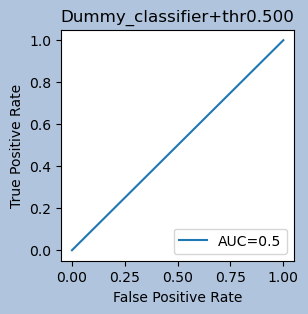

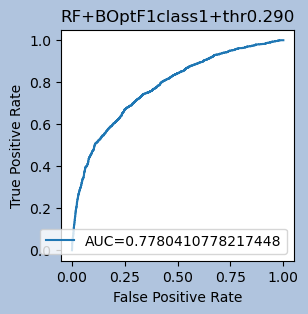

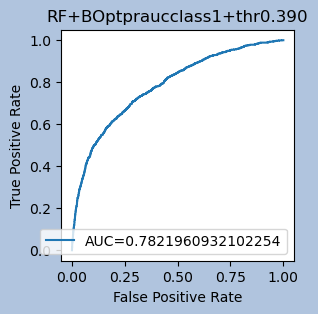

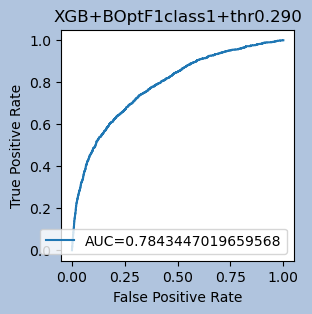

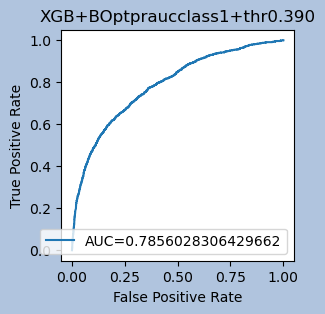

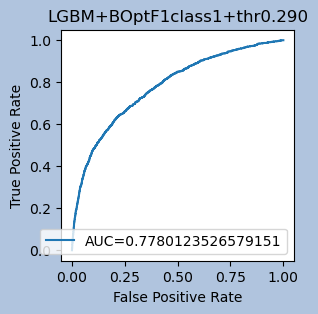

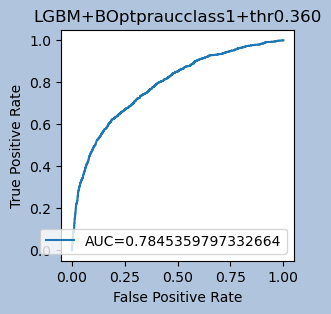

In [348]:
def evaluate_my_model(y_test, y_pred, y_probs, df_results, title):
  get_scores_report_classification(y_test, y_pred)
  plot_my_confusionmatrix(y_test.to_frame(), y_pred)
  plot_my_aucroc(y_test, y_probs, title)
  df_results = add_results(title, df_results, y_test, y_pred, y_probs)
  display(df_results)
  return df_results





from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc

def find_optimal_threshold_cv(model, X, y, cv_splits=5, metric_to_optimize="f1_weighted"):
    """
    Obtiene probabilidades con CV (out-of-fold) sobre TRAIN y busca el threshold
    que maximiza la métrica elegida.
    Devuelve: best_threshold, df_thresholds (opcional con métricas por threshold)
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # obtener probabilidades out-of-fold para la clase 1
    # cross_val_predict con method='predict_proba' devuelve proba por cada pliegue (oof)
    probs = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 99)
    best_thr = 0.5
    best_score = -np.inf
    rows = []

    for thr in thresholds:
        preds_thr = (probs >= thr).astype(int)

        if metric_to_optimize == "f1_weighted":
            score = f1_score(y, preds_thr, average="weighted", zero_division=0)
        
        elif metric_to_optimize == "f1_class1":
            score = f1_score(y, preds_thr, pos_label=1, zero_division=0)

        elif metric_to_optimize == "recall_class1":
            score = recall_score(y, preds_thr, pos_label=1, zero_division=0)

        elif metric_to_optimize == "prauc_class1":
            score = average_precision_score(y, preds_thr)

        else:
            raise ValueError("metric_to_optimize is not found")

        rows.append((thr, score))
        if score > best_score:
            best_score = score
            best_thr = thr

    # optional: return also the list
    df_thr = pd.DataFrame(rows, columns=["threshold", "score"])
    return best_thr, best_score, df_thr



def predict_with_threshold(model, X, threshold=0.5):
    """
    Devuelve predicciones binarias aplicando threshold sobre predict_proba[:,1].
    """
    probs = model.predict_proba(X)[:, 1] # probabilidades de clase positiva
    return (probs >= threshold).astype(int), probs



from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_cv_scores_report_classification(estimator, X, y, n_splits=5, n_repeats=1):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=333)
    def auc_class1(y_true, y_score):
        return roc_auc_score(y_true, y_score)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision_class1': make_scorer(precision_score, pos_label=1, zero_division=0),
        'recall_class1': make_scorer(recall_score, pos_label=1),
        'f1_class1': make_scorer(f1_score, pos_label=1),
        'aucroc_class1': make_scorer(auc_class1, needs_threshold=True)
    }
    cv_scores = cross_validate(estimator=estimator, X=X, y=y, scoring=scoring, cv=cv, n_jobs=-1)
    cv_scores = pd.DataFrame(cv_scores)

    print('====================================================================')
    print(f"Accuracy en CV: mean {cv_scores.test_accuracy.mean():.3f}, std {cv_scores.test_accuracy.std():.3f}")
    print(f"Precision clase1 en CV: mean {cv_scores.test_precision_class1.mean():.3f}, std {cv_scores.test_precision_class1.std():.3f}")
    print(f"Recall clase1 en CV: mean {cv_scores.test_recall_class1.mean():.3f}, std {cv_scores.test_recall_class1.std():.3f}")
    print(f"F1-Score clase1 en CV: mean {cv_scores.test_f1_class1.mean():.3f}, std {cv_scores.test_f1_class1.std():.3f}")
    print(f"AUCROC clase1 en CV: mean {cv_scores.test_aucroc_class1.mean():.3f}, std {cv_scores.test_aucroc_class1.std():.3f}")
    print('====================================================================')

    return cv_scores

def get_scores_report_classification(y_test, y_pred):
    print('====================================================================')
    print('Accuracy en y_pred: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision clase1 en y_pred: {:.3f}'.format(precision_score(y_test, y_pred, pos_label=1)))
    print('Recall clase1 en y_pred: {:.3f}'.format(recall_score(y_test, y_pred, pos_label=1)))
    print('F1-Score clase1 en y_pred: {:.3f}'.format(f1_score(y_test, y_pred, pos_label=1)))
    aucroc_class1 = roc_auc_score(y_test, y_pred)
    print('AUCROC clase1 en y_pred: {:.3f}'.format(aucroc_class1))
    print(classification_report(y_test, y_pred))
    print('====================================================================')



def train_and_evaluate_my_model(model, X_train, y_train, X_test, y_test, df_results, title,
                                find_threshold_on_train=False, threshold_metric="f1"):
    """
    model: modelo ya inicializado (puede venir de RF_BO)
    find_threshold_on_train: si True, busca cutoff óptimo en TRAIN mediante CV OOF.
    threshold_metric: 'f1' o 'recall'
    """
    # 1) entrenar sobre todo el train (si no está entrenado ya)
    model.fit(X_train, np.ravel(y_train))

    # 2) CV scores sobre TRAIN solamente
    get_cv_scores_report_classification(estimator=model, X=X_train, y=y_train, n_splits=5, n_repeats=3)

    # 3) encontrar cutoff óptimo en TRAIN (o usar 0.5)
    if find_threshold_on_train:
        best_thr, best_score, df_thr = find_optimal_threshold_cv(model, X_train, y_train, cv_splits=5, metric_to_optimize=threshold_metric)
        print(f"Cutoff óptimo (train oof) por {threshold_metric}: {best_thr:.3f} (score={best_score:.3f})")
    else:
        best_thr = 0.5
        print("Usando cutoff por defecto = 0.5")

    # 4) predecir en test con el cutoff encontrado
    y_pred_test, y_probs_test = predict_with_threshold(model, X_test, threshold=best_thr)

    # 5) evaluar y guardar resultados
    df_results = evaluate_my_model(y_test, y_pred_test, y_probs_test, df_results, title + f"+thr{best_thr:.3f}")
    return df_results, best_thr

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

def RF_BO(X_train_pp, y_train, metric="f1_weighted", max_evals=30, random_state=42):
    """
    Optimiza RandomForest sobre X_train_pp/y_train usando Hyperopt + CV interno.
    Nota: X_test_pp and y_test se aceptan por compatibilidad con tu firma
    pero NO se usan durante la optimización (evitar data leakage).
    
    metric: metrica
    Retorna: modelo final ajustado sobre TODO el train y los mejores parámetros.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    space = {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 501, 50, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(5, 51, 1, dtype=int)),
        "min_samples_split": hp.choice("min_samples_split", np.arange(2, 21, dtype=int)),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(1, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt", "log2"])
    }

    def objective(params):
        model = RandomForestClassifier(**params, n_jobs=-1, random_state=random_state)

        def func_prauc_class1(y_true, y_score):
            return average_precision_score(y_true, y_score)
        if metric == "f1_weighted":
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1).mean()
        elif metric == "f1_class1":
            f1_class1 = make_scorer(f1_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=f1_class1, n_jobs=-1).mean() 
        elif metric == "recall_class1":
            recall_class1 = make_scorer(recall_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=recall_class1, n_jobs=-1).mean()
        elif metric == "prauc_class1":
            prauc_class1 = make_scorer(func_prauc_class1, needs_threshold=True)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=prauc_class1, n_jobs=-1).mean()
        else:
            raise ValueError("Metric is not found")
        
        return {"loss": -score, "status": STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(random_state)
    )

    best_params = space_eval(space, best)
    print("Mejores parámetros encontrados (train CV en RF):", best_params)

    # Entrenar modelo final con TODO el train
    best_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=random_state)
    best_model.fit(X_train_pp, y_train)

    return best_model, best_params



from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from xgboost import XGBClassifier

def XGBoost_BO(X_train_pp, y_train, metric="f1_weighted", max_evals=30, random_state=42):
    """
    Optimiza XGBoost con Hyperopt usando CV interno.
    Retorna dupla: (best_model, best_params)
    """
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    space = {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 601, 100, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(3, 11, dtype=int)),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
        "subsample": hp.uniform("subsample", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
        "gamma": hp.uniform("gamma", 0, 5),
        "min_child_weight": hp.uniform("min_child_weight", 0, 10)
    }

    def objective(params):
        model = XGBClassifier(
            **params,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=random_state,
            n_jobs=-1
        )

        def func_prauc_class1(y_true, y_score):
            return average_precision_score(y_true, y_score)
        if metric == "f1_weighted":
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1).mean()
        elif metric == "f1_class1":
            f1_class1 = make_scorer(f1_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=f1_class1, n_jobs=-1).mean() 
        elif metric == "recall_class1":
            recall_class1 = make_scorer(recall_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=recall_class1, n_jobs=-1).mean()
        elif metric == "prauc_class1":
            prauc_class1 = make_scorer(func_prauc_class1, needs_threshold=True)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=prauc_class1, n_jobs=-1).mean()
        else:
            raise ValueError("Metric is not found")        

        return {"loss": -score, "status": STATUS_OK}

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                rstate=np.random.default_rng(random_state))

    best_params = space_eval(space, best)
    print("Mejores parámetros encontrados (train CV en XGBoost):", best_params)

    # Entrena modelo final sobre TODO el train
    best_model = XGBClassifier(
        **best_params,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=random_state,
        n_jobs=-1
    )
    best_model.fit(X_train_pp, y_train)

    return best_model, best_params




import lightgbm as lgb

def LightGBM_BO(X_train_pp, y_train, metric="f1_weighted", max_evals=30, random_state=42):
    """
    Optimiza LightGBM con Hyperopt usando CV interno.
    Retorna dupla: (best_model, best_params)
    """

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    space = {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 601, 100, dtype=int)),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
        "num_leaves": hp.choice("num_leaves", np.arange(20, 200, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(3, 11, dtype=int)),
        "subsample": hp.uniform("subsample", 0.6, 1.0),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
        "min_child_samples": hp.choice("min_child_samples", np.arange(5, 51, dtype=int))
    }

    def objective(params):
        model = lgb.LGBMClassifier(
            **params,
            objective="binary",
            n_jobs=-1,
            random_state=random_state
        )

        def func_prauc_class1(y_true, y_score):
            return average_precision_score(y_true, y_score)
        if metric == "f1_weighted":
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1).mean()
        elif metric == "f1_class1":
            f1_class1 = make_scorer(f1_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=f1_class1, n_jobs=-1).mean() 
        elif metric == "recall_class1":
            recall_class1 = make_scorer(recall_score, pos_label=1)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=recall_class1, n_jobs=-1).mean()
        elif metric == "prauc_class1":
            prauc_class1 = make_scorer(func_prauc_class1, needs_threshold=True)
            score = cross_val_score(model, X_train_pp, y_train, cv=cv, scoring=prauc_class1, n_jobs=-1).mean()
        else:
            raise ValueError("Metric is not found")

        return {"loss": -score, "status": STATUS_OK}

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                rstate=np.random.default_rng(random_state))

    best_params = space_eval(space, best)
    print("Mejores parámetros encontrados (train CV en LightGBM):", best_params)

    # Entrena modelo final
    best_model = lgb.LGBMClassifier(
        **best_params,
        objective="binary",
        n_jobs=-1,
        random_state=random_state
    )
    best_model.fit(X_train_pp, y_train)

    return best_model, best_params




clf_dummy = DummyClassifier(random_state=42) #establishing random_state for reproducibility
df_results, theshold_dummy = train_and_evaluate_my_model(clf_dummy, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results, 
                                         "Dummy_classifier")

# 1) hallas modelos optimizados (solo sobre train)
#rf_optf1weighted, bestparams_rf_optf1weighted = RF_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_weighted", max_evals=20)
#rf_optrecallclass1, bestparams_rf_optrecallclass1 = RF_BO(X_clf_train_bal, y_clf_train_bal, metric="recall_class1", max_evals=10)
rf_optf1class1, bestparams_rf_optf1class1 = RF_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_class1", max_evals=30)
rf_optpraucclass1, bestparams_rf_optpraucclass1 = RF_BO(X_clf_train_bal, y_clf_train_bal, metric="prauc_class1", max_evals=30)

#xgb_optf1weighted, bestparams_xgb_optf1weighted = XGBoost_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_weighted", max_evals=20)
#xgb_optrecallclass1, bestparams_xgb_optrecallclass1 = XGBoost_BO(X_clf_train_bal, y_clf_train_bal, metric="recall_class1", max_evals=10)
xgb_optf1class1, bestparams_xgb_optf1class1 = XGBoost_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_class1", max_evals=30)
xgb_optpraucclass1, bestparams_xgb_optpraucclass1 = XGBoost_BO(X_clf_train_bal, y_clf_train_bal, metric="prauc_class1", max_evals=30)

#lgbm_optf1weighted, bestparams_lgbm_optf1weighted = LightGBM_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_weighted", max_evals=20)
#lgbm_optrecallclass1, bestparams_lgbm_optrecallclass1 = LightGBM_BO(X_clf_train_bal, y_clf_train_bal, metric="recall_class1", max_evals=10)
lgbm_optf1class1, bestparams_lgbm_optf1class1 = LightGBM_BO(X_clf_train_bal, y_clf_train_bal, metric="f1_class1", max_evals=30)
lgbm_optpraucclass1, bestparams_lgbm_optpraucclass1 = LightGBM_BO(X_clf_train_bal, y_clf_train_bal, metric="prauc_class1", max_evals=30)

# 2) entrenas y evaluas (el umbral se elige en TRAIN OOF y luego se aplica a TEST)
#df_results, threshold_rf_f1weighted = train_and_evaluate_my_model(rf_optf1weighted, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "RF+BOptF1weighted", find_threshold_on_train=True, threshold_metric="f1_weighted")

df_results, threshold_rf_f1class1 = train_and_evaluate_my_model(rf_optf1class1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "RF+BOptF1class1", find_threshold_on_train=True, threshold_metric="f1_class1")

#df_results, threshold_rf_recallclass1 = train_and_evaluate_my_model(rf_optrecallclass1, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "RF+BOptRecallclass1", find_threshold_on_train=True, threshold_metric="recall_class1")

df_results, threshold_rf_praucclass1 = train_and_evaluate_my_model(rf_optpraucclass1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "RF+BOptpraucclass1", find_threshold_on_train=True, threshold_metric="prauc_class1")



#df_results, threshold_xgb_f1weighted = train_and_evaluate_my_model(xgb_optf1weighted, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "XGB+BOptF1weighted", find_threshold_on_train=True, threshold_metric="f1_weighted")

df_results, threshold_xgb_f1class1 = train_and_evaluate_my_model(xgb_optf1class1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "XGB+BOptF1class1", find_threshold_on_train=True, threshold_metric="f1_class1")

#df_results, threshold_xgb_recallclass1 = train_and_evaluate_my_model(xgb_optrecallclass1, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "XGB+BOptRecallclass1", find_threshold_on_train=True, threshold_metric="recall_class1")

df_results, threshold_xgb_praucclass1 = train_and_evaluate_my_model(xgb_optpraucclass1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "XGB+BOptpraucclass1", find_threshold_on_train=True, threshold_metric="prauc_class1")



#df_results, threshold_lgbm_f1weighted = train_and_evaluate_my_model(lgbm_optf1weighted, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "LGBM+BOptF1weighted", find_threshold_on_train=True, threshold_metric="f1_weighted")

df_results, threshold_lgbm_f1class1 = train_and_evaluate_my_model(lgbm_optf1class1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "LGBM+BOptF1class1", find_threshold_on_train=True, threshold_metric="f1_class1")

#df_results, threshold_lgbm_recallclass1 = train_and_evaluate_my_model(lgbm_optrecallclass1, X_clf_train_bal, y_clf_train_bal,
#                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
#                                         "LGBM+BOptRecallclass1", find_threshold_on_train=True, threshold_metric="recall_class1")

df_results, threshold_lgbm_praucclass1 = train_and_evaluate_my_model(lgbm_optpraucclass1, X_clf_train_bal, y_clf_train_bal,
                                         X_test_clf_fe_rf_df, y_clf_test, df_results,
                                         "LGBM+BOptpraucclass1", find_threshold_on_train=True, threshold_metric="prauc_class1")


In [349]:
gfg

NameError: name 'gfg' is not defined

#### Feature Engineering

In [ ]:
def feature_engineering_general(df):
    df_fe = df.copy()
    
    # --- CATEGÓRICAS ---
    cat_cols = ['cat_SEX', 'cat_EDUCATION', 'cat_MARRIAGE']
    df_fe = pd.get_dummies(df_fe, columns=cat_cols, drop_first=True)

    # --- ESTATUS DE PAGOS PASADOS ---
    pay_cols = [col for col in df.columns if col.startswith("cat_PAY")]
    df_fe['mean_pay_status'] = df_fe[pay_cols].mean(axis=1)
    df_fe['max_pay_status'] = df_fe[pay_cols].max(axis=1)
    df_fe['num_delays'] = (df_fe[pay_cols] > 0).sum(axis=1)  # retrasos > 0

    # --- FACTURAS Y PAGOS ---
    bill_cols = [col for col in df.columns if col.startswith("num_BILL")]
    pay_amt_cols = [col for col in df.columns if col.startswith("num_PAY")]
    
    df_fe['total_bill'] = df_fe[bill_cols].sum(axis=1)
    df_fe['avg_bill'] = df_fe[bill_cols].mean(axis=1)
    df_fe['total_prev_pay'] = df_fe[pay_amt_cols].sum(axis=1)
    df_fe['avg_prev_pay'] = df_fe[pay_amt_cols].mean(axis=1)
    df_fe['bill_payment_ratio'] = df_fe['total_prev_pay'] / (df_fe['total_bill'] + 1)  # +1 para evitar div 0
    
    # --- DIFERENCIAS ENTRE MESES ---
    for cols, name in zip([bill_cols, pay_amt_cols], ['bill', 'pay']):
        # Ordenar las columnas según el número al final para no confundir el orden
        sorted_cols = sorted(cols, key=lambda x: int(''.join(filter(str.isdigit, x))))
        for i in range(1, len(sorted_cols)):
            df_fe[f'{name}_diff_{i+1}'] = df_fe[sorted_cols[i-1]] - df_fe[sorted_cols[i]]

    # --- INTERACCIONES Y OTRAS ---
    df_fe['balance_per_age'] = df_fe['num_LIMIT_BAL'] / (df_fe['num_AGE'] + 1)
    df_fe['credit_utilization'] = df_fe['total_bill'] / (df_fe['num_LIMIT_BAL'] + 1)

    return df_fe

df_reg = feature_engineering_general(df_reg)
df_clasif = feature_engineering_general(df_clasif)

display(df_reg.info())
display(df_clasif.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_LIMIT_BAL       29400 non-null  int64  
 1   num_AGE             29400 non-null  int64  
 2   cat_PAY_5           29400 non-null  int64  
 3   cat_PAY_6           29400 non-null  int64  
 4   num_BILL_AMT4       29400 non-null  int64  
 5   num_BILL_AMT5       29400 non-null  int64  
 6   num_BILL_AMT6       29400 non-null  int64  
 7   tgt_PAY_AMT4        29400 non-null  int64  
 8   num_PAY_AMT5        29400 non-null  int64  
 9   num_PAY_AMT6        29400 non-null  int64  
 10  cat_SEX_2           29400 non-null  bool   
 11  cat_EDUCATION_2     29400 non-null  bool   
 12  cat_EDUCATION_3     29400 non-null  bool   
 13  cat_EDUCATION_4     29400 non-null  bool   
 14  cat_MARRIAGE_2      29400 non-null  bool   
 15  cat_MARRIAGE_3      29400 non-null  bool   
 16  mean_pay_

None

<class 'pandas.core.frame.DataFrame'>
Index: 29400 entries, 0 to 29999
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_LIMIT_BAL                   29400 non-null  int64  
 1   num_AGE                         29400 non-null  int64  
 2   cat_PAY_0                       29400 non-null  int64  
 3   cat_PAY_2                       29400 non-null  int64  
 4   cat_PAY_3                       29400 non-null  int64  
 5   cat_PAY_4                       29400 non-null  int64  
 6   cat_PAY_5                       29400 non-null  int64  
 7   cat_PAY_6                       29400 non-null  int64  
 8   num_BILL_AMT1                   29400 non-null  int64  
 9   num_BILL_AMT2                   29400 non-null  int64  
 10  num_BILL_AMT3                   29400 non-null  int64  
 11  num_BILL_AMT4                   29400 non-null  int64  
 12  num_BILL_AMT5                   29400

None

In [ ]:
mytarget = "tgt_default_payment_next_month"
target_counts = df_clasif[mytarget].value_counts()
fig = px.bar(target_counts, x=target_counts.index, y=target_counts.values, title="Target Counts", labels={'x': 'Target', 'y': 'Count'})
fig.show()

#### Separación en datos de entrenamiento y evaluación

In [ ]:
# ===============================
# FUNCIONES PARA MODELOS NO LINEALES
# ===============================



# ---------------------------
# REGRESIÓN
# ---------------------------
def run_regression_models(df, target='tgt_PAY_AMT4', test_size=0.2, random_state=42):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state),
        'LightGBM': LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2, 'Feature_importances': getattr(model, 'feature_importances_', None)}
        
        print(f"--- {name} ---")
        print(f"RMSE: {rmse:.2f}, R2: {r2:.4f}\n")
    
    return results


In [ ]:
results_reg = run_regression_models(df_reg)

KeyboardInterrupt: 

In [ ]:



# ---------------------------
# CLASIFICACIÓN CON RESUMEN Y PLOTS OPCIONALES
# ---------------------------



def run_classification_models_summary(df, target='tgt_default_payment_next_month',
                                      test_size=0.2, random_state=42,
                                      use_balanced_pipeline=False,
                                      plot_metrics=False):
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Separar train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Pipeline de over+under sampling
    if use_balanced_pipeline:
        over = SMOTE(random_state=random_state)
        #under = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)
        steps = [('o', over)] #, ('u', under)]
        smt = Pipeline(steps=steps)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        print(f"✅ Pipeline SMOTE+Under aplicado: proporciones en entrenamiento:\n{pd.Series(y_train).value_counts()}")
    
    # Modelos
    models = {
        'Dummy': DummyClassifier(strategy='most_frequent'),
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    # Lista para resultados
    summary = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        
        summary.append({
            'Model': name,
            'Accuracy': acc,
            'ROC_AUC': roc,
            'Precision_class1': precision,
            'Recall_class1': recall,
            'F1_class1': f1
        })
        
        print(f"--- {name} ---")
        print(classification_report(y_test, y_pred))
        
        if plot_metrics:
            # Confusion matrix
            plot_my_confusionmatrix(y_test.to_frame(), y_pred)
            # ROC curve
            plot_my_aucroc(y_test, y_proba, title=f'{name} ROC Curve')
    
    summary_df = pd.DataFrame(summary)
    return summary_df


✅ Pipeline SMOTE+Under aplicado: proporciones en entrenamiento:
tgt_default_payment_next_month
0    18301
1    18301
Name: count, dtype: int64
--- Dummy ---
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4575
           1       0.00      0.00      0.00      1305

    accuracy                           0.78      5880
   macro avg       0.39      0.50      0.44      5880
weighted avg       0.61      0.78      0.68      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



--- RandomForest ---
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4575
           1       0.57      0.48      0.52      1305

    accuracy                           0.81      5880
   macro avg       0.72      0.69      0.70      5880
weighted avg       0.80      0.81      0.80      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[12:43:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




--- XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4575
           1       0.56      0.41      0.47      1305

    accuracy                           0.80      5880
   macro avg       0.70      0.66      0.67      5880
weighted avg       0.78      0.80      0.78      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


[LightGBM] [Info] Number of positive: 18301, number of negative: 18301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8048
[LightGBM] [Info] Number of data points in the train set: 36602, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  Accuracy   ROC_AUC  Precision_class1  Recall_class1  \
0         Dummy  0.778061  0.500000          0.000000       0.000000   
1  RandomForest  0.805102  0.775204          0.572338       0.481992   
2       XGBoost  0.796259  0.754259          0.555212       0.412261   
3      LightGBM  0.801531  0.757418          0.571429       0.422989   

   F1_class1  
0   0.000000  
1   0.523295  
2   0.473175  
3   0.486129

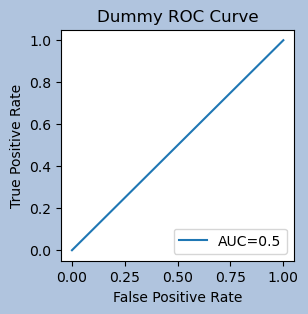

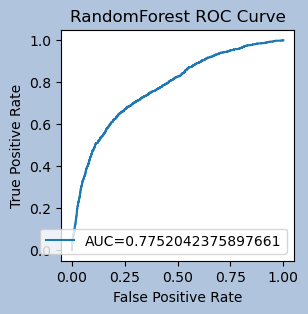

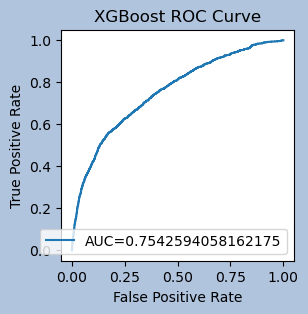

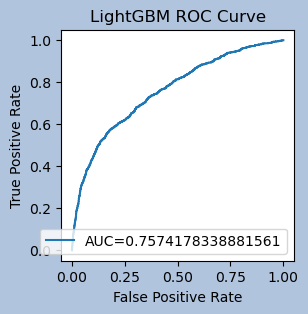

In [ ]:
summary_df_plots = run_classification_models_summary(df_clasif, use_balanced_pipeline=True, plot_metrics=True)
display(summary_df_plots)

In [ ]:
'''



'''

'\n\ndef get_predictions_with_optimalcutoffpoint(model, X_test, y_test):\n\n  # Obtener probabilidades predictivas\n  probabilities = model.predict_proba(X_test)[:, 1]  # Probabilidad de que el target sea 1\n  #print(probabilities)\n\n  # Calcular la curva ROC y el AUC-ROC\n  fpr, tpr, thresholds = roc_curve(y_test, probabilities)\n  roc_auc = auc(fpr, tpr)\n\n  # Graficar la curva ROC\n  plt.figure()\n  plt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=f\'AUC = {roc_auc:.2f}\')\n  plt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\n  plt.xlabel(\'Tasa de Falsos Positivos (1 - Especificidad)\')\n  plt.ylabel(\'Tasa de Verdaderos Positivos (Sensibilidad)\')\n  plt.title(\'Curva ROC\')\n  plt.legend(loc=\'lower right\')\n  plt.show()\n\n  # Encontrar el umbral óptimo basado en la curva ROC\n  optimal_idx = np.argmax(tpr - fpr)\n  optimal_threshold = thresholds[optimal_idx]\n  print(f\'Umbral óptimo según la curva ROC: {optimal_threshold:.2f}\')\n\n  # Clasificar las pred

In [ ]:
'''
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
X_clf = df_clasif.drop(columns=['tgt_default_payment_next_month'])
y_clf = pd.Series(df_clasif['tgt_default_payment_next_month'])

display(X_clf)
display(y_clf)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)



clf_dummy = DummyClassifier(random_state=42) #establishing random_state for reproducibility
df_results = train_and_evaluate_my_model(clf_dummy, X_clf_train, y_clf_train, X_clf_test, y_clf_test, df_results, "Dummy_classifier")
'''

'\nfrom sklearn.model_selection import cross_validate\nfrom sklearn.metrics import make_scorer\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nX_clf = df_clasif.drop(columns=[\'tgt_default_payment_next_month\'])\ny_clf = pd.Series(df_clasif[\'tgt_default_payment_next_month\'])\n\ndisplay(X_clf)\ndisplay(y_clf)\n\nX_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(\n    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf\n)\n\n\n\nclf_dummy = DummyClassifier(random_state=42) #establishing random_state for reproducibility\ndf_results = train_and_evaluate_my_model(clf_dummy, X_clf_train, y_clf_train, X_clf_test, y_clf_test, df_results, "Dummy_classifier")\n'

In [ ]:
def run_classification_models_summary(df, target='tgt_default_payment_next_month',
                                      test_size=0.2, random_state=42,
                                      use_balanced_pipeline=False,
                                      plot_metrics=False,
                                      plot_threshold=False):
    
    X = df.drop(columns=[target])
    y = df[target]
    
    # Separar train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Pipeline de over sampling
    if use_balanced_pipeline:
        over = SMOTE(random_state=random_state)
        steps = [('o', over)]
        smt = Pipeline(steps=steps)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        print(f"✅ Pipeline SMOTE aplicado: proporciones en entrenamiento:\n{pd.Series(y_train).value_counts()}")
    
    # Modelos
    models = {
        'Dummy': DummyClassifier(strategy='most_frequent'),
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
    }
    
    summary = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:,1]

        # --- Encontrar umbral que maximiza F1 de la clase 1 ---
        thresholds = np.arange(0.1, 0.9, 0.01)
        f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), pos_label=1) for t in thresholds]
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        y_pred_opt = (y_proba >= best_threshold).astype(int)
        
        # Métricas usando umbral óptimo
        acc = accuracy_score(y_test, y_pred_opt)
        roc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred_opt, pos_label=1)
        recall = recall_score(y_test, y_pred_opt, pos_label=1)
        f1 = f1_score(y_test, y_pred_opt, pos_label=1)
        
        summary.append({
            'Model': name,
            'Accuracy': acc,
            'ROC_AUC': roc,
            'Precision_class1': precision,
            'Recall_class1': recall,
            'F1_class1': f1,
            'Best_threshold': best_threshold
        })
        
        print(f"--- {name} ---")
        print(f"Umbral óptimo para F1 de clase 1: {best_threshold:.2f}")
        print(classification_report(y_test, y_pred_opt))
        
        if plot_metrics:
            plot_my_confusionmatrix(y_test.to_frame(), y_pred_opt)
            plot_my_aucroc(y_test, y_proba, title=f'{name} ROC Curve')
        
        if plot_threshold:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(7,4))
            plt.plot(thresholds, f1_scores, label='F1')
            plt.axvline(best_threshold, color='red', linestyle='--', label=f'Umbral óptimo {best_threshold:.2f}')
            plt.xlabel('Threshold')
            plt.ylabel('F1-score')
            plt.title(f'F1 vs Threshold - {name}')
            plt.legend()
            plt.show()
    
    summary_df = pd.DataFrame(summary)
    return summary_df


--- Dummy ---
Umbral óptimo para F1 de clase 1: 0.10
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4575
           1       0.00      0.00      0.00      1305

    accuracy                           0.78      5880
   macro avg       0.39      0.50      0.44      5880
weighted avg       0.61      0.78      0.68      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



--- RandomForest ---
Umbral óptimo para F1 de clase 1: 0.26
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      4575
           1       0.50      0.59      0.54      1305

    accuracy                           0.78      5880
   macro avg       0.69      0.71      0.70      5880
weighted avg       0.79      0.78      0.79      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\ALESSIOPC\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning:

[12:43:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




--- XGBoost ---
Umbral óptimo para F1 de clase 1: 0.23
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4575
           1       0.46      0.63      0.53      1305

    accuracy                           0.76      5880
   macro avg       0.67      0.71      0.68      5880
weighted avg       0.79      0.76      0.77      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


[LightGBM] [Info] Number of positive: 5219, number of negative: 18301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7641
[LightGBM] [Info] Number of data points in the train set: 23520, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221896 -> initscore=-1.254650
[LightGBM] [Info] Start training from score -1.254650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



--- LightGBM ---
Umbral óptimo para F1 de clase 1: 0.32
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4575
           1       0.54      0.52      0.53      1305

    accuracy                           0.80      5880
   macro avg       0.70      0.70      0.70      5880
weighted avg       0.79      0.80      0.79      5880

Distribution of test data: 
 tgt_default_payment_next_month
0                                 0.778061
1                                 0.221939
Name: proportion, dtype: float64


C:\Users\ALESSIOPC\AppData\Local\Temp\ipykernel_35808\824237704.py:54: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Model  Accuracy   ROC_AUC  Precision_class1  Recall_class1  \
0         Dummy  0.778061  0.500000          0.000000       0.000000   
1  RandomForest  0.780102  0.781485          0.503932       0.589272   
2       XGBoost  0.755782  0.774828          0.463015       0.628352   
3      LightGBM  0.795918  0.775413          0.541634       0.523372   

   F1_class1  Best_threshold  
0   0.000000            0.10  
1   0.543271            0.26  
2   0.533160            0.23  
3   0.532346            0.32

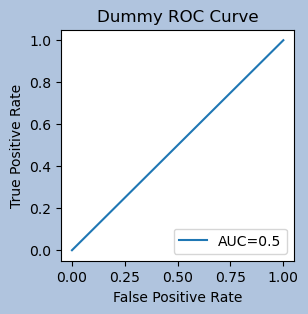

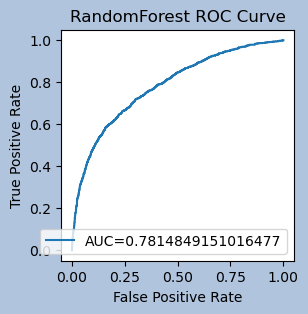

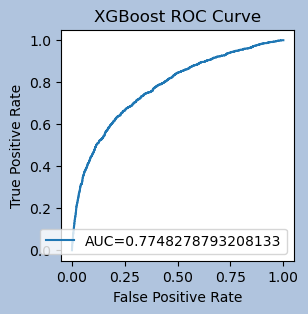

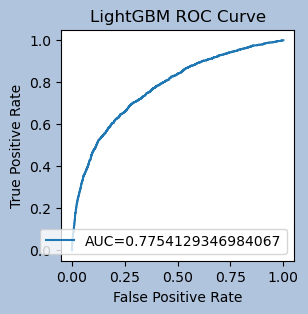

In [ ]:
summary_df = run_classification_models_summary(
    df_clasif,
    use_balanced_pipeline=False,
    plot_metrics=True,
    plot_threshold=False
)

display(summary_df)